#구조화된 데이터 
## 정형 데이터 다루기
- 정형데이터 다루는 방법을 소개하는 파트 <br>

1) 비정형데이터 <br>
- 비구조화 데이터로 정해진 형식 없이 모든 데이터가 포함되어 있음 
- ex_ sns 데이터 등

2) 반정형데이터
- 정형데이터처럼 고정된 필드에 저장된 데이터는 아니지만, 비정형처럼 마구잡이로 섞인 데이터도 아닌 형태
- ex_ XML, HTML텍스트 등

3) 정형데이터 
- 고정된 필드에 저장된 데이터 
- ex_ DB, CSV 등

<br>
케라스를 사용하여 모델을 정의하고 feature_column을 사용하여 CSV의 열을 모델 훈련에 필요한 특성으로 매핑 <br>

이 튜토리얼에 포함되어 있는 것 <br>
1. pandas를 사용하여 CSV파일을 읽기
2. tf.data를 사용하여 행을 섞고 배치로 나누는 입력 파이프라인을 만들기 
3. csv의 열을 feature_column을 사용해 모델 후련에 필요한 특성으로 매핑하기
4. 케라스를 사용하여 모델 구축,훈련, 평가하기 



### 데이터 셋

PetFinder 데이터셋 사용 <br>
- 각 행은 애완동물을 설명
> 애완동물이 입양되는 속도를 예측

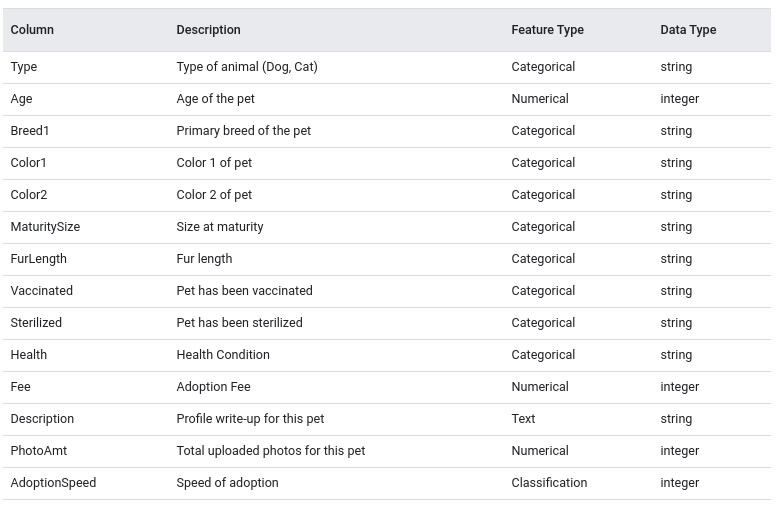

In [38]:
# 필요한 라이브러리
import numpy as np
import pandas as pd

import tensorflow as tf

from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split


In [39]:
# pandas로 데이터프레임 만들기

import pathlib

dataset_url = 'http://storage.googleapis.com/download.tensorflow.org/data/petfinder-mini.zip'
csv_file = 'datasets/petfinder-mini/petfinder-mini.csv'

tf.keras.utils.get_file('petfinder_mini.zip', dataset_url,
                        extract=True, cache_dir='.')
dataframe = pd.read_csv(csv_file)

In [40]:
dataframe.head()

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,Description,PhotoAmt,AdoptionSpeed
0,Cat,3,Tabby,Male,Black,White,Small,Short,No,No,Healthy,100,Nibble is a 3+ month old ball of cuteness. He ...,1,2
1,Cat,1,Domestic Medium Hair,Male,Black,Brown,Medium,Medium,Not Sure,Not Sure,Healthy,0,I just found it alone yesterday near my apartm...,2,0
2,Dog,1,Mixed Breed,Male,Brown,White,Medium,Medium,Yes,No,Healthy,0,Their pregnant mother was dumped by her irresp...,7,3
3,Dog,4,Mixed Breed,Female,Black,Brown,Medium,Short,Yes,No,Healthy,150,"Good guard dog, very alert, active, obedience ...",8,2
4,Dog,1,Mixed Breed,Male,Black,No Color,Medium,Short,No,No,Healthy,0,This handsome yet cute boy is up for adoption....,3,2


In [41]:
# target 열 생성
# 원래는 애완동물이 입양될 속도를 예측하는데 여기서는 이진 분류문제로 변환하고 
# 단순히 애완동물이 입양되었는지 여부만 예측

# 0 : 입양 x 
# 1 : 입양 o

# 새로운 타겟 열 생성
dataframe['target'] = np.where(dataframe['AdoptionSpeed']==4, 0, 1)

# 기존 타겟열 삭제
dataframe = dataframe.drop(columns=['AdoptionSpeed', 'Description'])


In [42]:
# 데이터프레임을 훈련, 검증 , 테스트로 나눔

train, test = train_test_split(dataframe, test_size=0.2) 
train, val = train_test_split(train, test_size=0.2)
print(len(train), '훈련 샘플')
print(len(val), '검증 샘플')
print(len(test), '테스트 샘플')

7383 훈련 샘플
1846 검증 샘플
2308 테스트 샘플


In [35]:
# tf.data를 사용하여 입력 파이프라인 만들기

# tf.data를 이용해서 데이터프레임을 감싼다. 
# feature_column를 사용하여 판다스 데이터프레임의 열을 모델 훈련에 필요한 특성으로 매핑
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('target')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

# 만약 아주 큰 csv파일을 다룬다면 tf.data로 디스크 디렉토리에서 데이터를 읽을 수도 있다.

In [43]:
# 예제를 위해 작은 배치 크기를 사용

batch_size = 5 
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

### 입력 파이프라인 이해하기


In [44]:
# 입력 파이프라인을 호출해서 반환하는 데이터 포맷 확인

for feature_batch, label_batch in train_ds.take(1):
  print('Every feature:', list(feature_batch.keys()))

  # 배치사이즈를 5로 하였기에 5개의 값만 나옴
  print('A batch of ages:', feature_batch['Age'])
  print('A batch of targets:', label_batch )

Every feature: ['Type', 'Age', 'Breed1', 'Gender', 'Color1', 'Color2', 'MaturitySize', 'FurLength', 'Vaccinated', 'Sterilized', 'Health', 'Fee', 'PhotoAmt']
A batch of ages: tf.Tensor([ 3  2 12 36  6], shape=(5,), dtype=int64)
A batch of targets: tf.Tensor([1 1 1 1 0], shape=(5,), dtype=int64)


### 여러 유형의 특성 열 시연

- tensorflow는 다양한 유형의 특성 열을 제공함
- 몇 가지 유형의 특성 열을 만들고 데이터 프레임에서 열을 변환하는 방법을 보여줌

In [45]:
# 이 배치를 이용해 여러 유형의 피쳐 열을 시연
example_batch = next(iter(train_ds))[0]

In [47]:
# 특성 열을 만들고 배치 데이터를 변환하는 함수를 이용
def demo(feature_column):
  feature_layer = layers.DenseFeatures(feature_column)
  print(feature_layer(example_batch).numpy())

In [48]:
# 수치형 열

# 수치형 열은 가장 간단한 종류의 열
# 데이터 프레임에서 변경되지 않은 열값을 받음

photo_count = feature_column.numeric_column('PhotoAmt')
demo(photo_count)

[[5.]
 [2.]
 [4.]
 [3.]
 [5.]]


In [49]:
# 버킷형 열

# 수치 값의 구간을 나누어 이를 기반으로 범주형으로 변환
# 나이 열을 보면 버킷화된 것을 볼 수 있음
age = feature_column.numeric_column('Age')
age_buckets = feature_column.bucketized_column(age, boundaries=[1, 3, 5])
demo(age_buckets)

[[0. 0. 1. 0.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]
 [0. 1. 0. 0.]]


In [50]:
# 범주형 열

# 모델에 문자열을 넣을 수 없기에 숫자값으로 매핑해야 된다.
# dog, cat을 원-핫 벡터로 표현함
animal_type = feature_column.categorical_column_with_vocabulary_list(
      'Type', ['Cat', 'Dog'])

animal_type_one_hot = feature_column.indicator_column(animal_type)
demo(animal_type_one_hot)

[[1. 0.]
 [0. 1.]
 [1. 0.]
 [0. 1.]
 [1. 0.]]


In [51]:
# 임베딩 열

# 범주마다 문자열이 몇 개가 있는 것이 아니라 수천 개씩 있으면 원-핫 인코딩을 하는 것은 불가능
# 그래서 임베딩 열을 사용하여 이런 제한을 극복

# 0또는 1이 아니라 밀집 벡터를 추가
# 범주형 열에 가능한 값이 많을 때는 임베딩 열을 사용하는 것이 최선

breed1 = feature_column.categorical_column_with_vocabulary_list(
      'Breed1', dataframe.Breed1.unique())
breed1_embedding = feature_column.embedding_column(breed1, dimension=8)
demo(breed1_embedding)

[[ 0.38490343  0.07682794  0.3635857   0.23241915 -0.5620926   0.25570053
   0.6900472  -0.01976215]
 [-0.52673095 -0.013064    0.14226273 -0.5574284  -0.2678971   0.18935551
  -0.33149084 -0.45622632]
 [-0.04899444  0.37372348 -0.39159155  0.01612325 -0.10622328  0.20486997
   0.10719655  0.58414596]
 [ 0.09473456 -0.14345226  0.38179454  0.2476315   0.6256442   0.3495873
  -0.21935436 -0.29441985]
 [-0.35300776 -0.18824896 -0.32485098 -0.03733625  0.3311015  -0.04389423
   0.16369815 -0.1478311 ]]


In [53]:
# 해시 특성 열 

# 범주마다 문자열이 많다면 임베딩 방법 말고  categorical_column_with_hash_bucket을 사용하는 방법이 있다.
# 해시 값을 계산한 다음 hash_bucket_size 크기의 버킷 중 하나를 선택하여 문자열을 인코딩한다.

# 어휘목록을 제공할 필요가 없고,
# 메모리를 위해 실제 범주의 개수보다 훨씬 작게하여 버킷의 크기를 정할 수 있다.

# 단점 : 다른 문자열이 동일한 버킷에 매핑되어 충돌할 수 있다는 것.
breed1_hashed = feature_column.categorical_column_with_hash_bucket(
      'Breed1', hash_bucket_size=10)
demo(feature_column.indicator_column(breed1_hashed))

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [54]:
# 교차 특성 열

# 여러 특성을 연결하여 하나의 특성으로 만드는 것을 교차 특성이라고 한다.
# 모델이 특성의 조합에 대한 가중치를 학습할 수 있다.

# 이 예제에서는 age 와 type을 교차 특성열로 만듬
# 가능한 조합에 대한 해시 테이블을 안 만들고 hashed_column 매개변수를 사용해 해시 테이블의 크기를 선택
crossed_feature = feature_column.crossed_column([age_buckets, animal_type], hash_bucket_size=10)
demo(feature_column.indicator_column(crossed_feature))

[[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


### 사용할 열 선택하기 

- 지금까지 소개한 열을 사용해서 모델을 훈련
- 특성 열을 사용하여 가벼운 훈련을 시킬꺼라서 모든 열 사용 x

In [55]:
feature_columns = []

# 수치형 열
for header in ['PhotoAmt', 'Fee', 'Age']:
  feature_columns.append(feature_column.numeric_column(header))

# 버킷형 열
age = feature_column.numeric_column('Age')
age_buckets = feature_column.bucketized_column(age, boundaries=[1, 2, 3, 4, 5])
feature_columns.append(age_buckets)

# 범주형 열
indicator_column_names = ['Type', 'Color1', 'Color2', 'Gender', 'MaturitySize',
                          'FurLength', 'Vaccinated', 'Sterilized', 'Health']
for col_name in indicator_column_names:
  categorical_column = feature_column.categorical_column_with_vocabulary_list(
      col_name, dataframe[col_name].unique())
  indicator_column = feature_column.indicator_column(categorical_column)
  feature_columns.append(indicator_column)

# 임베딩 열
breed1 = feature_column.categorical_column_with_vocabulary_list(
      'Breed1', dataframe.Breed1.unique())
breed1_embedding = feature_column.embedding_column(breed1, dimension=8)
feature_columns.append(breed1_embedding)

# 교차 특성 열
age_type_feature = feature_column.crossed_column([age_buckets, animal_type], hash_bucket_size=100)
feature_columns.append(feature_column.indicator_column(age_type_feature))

In [56]:
# 특성 층 생성
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [57]:
# 입력 파이프라인 생성
batch_size = 32
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

### 모델 생성, 컴파일, 훈련

In [58]:
model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dropout(.1),
  layers.Dense(1)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.fit(train_ds,
          validation_data=val_ds,
          epochs=10)

Epoch 1/10
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
218/231 [===========================>..] - ETA: 0s - loss: 0.6834 - accuracy: 0.6786WARNING:tensorflow:Layers in a Sequential model should only have a single input tensor, but we receive a <class 'dict'> input: {'Type': <tf.Tensor 'ExpandDims_11:0' shape=(None, 1) dtype=string>, 'Age': <tf.Tensor 'ExpandDims:0' shape=(None, 1) dtype=int64>, 'Breed1': <tf.Tensor 'ExpandDims_1:0' shape=(None, 1) dtype=string>, 'Gender': <tf.Tensor 'ExpandDims_6:0' shape=(None, 1) dtype=string>, 'Color1': <tf.Tensor 'ExpandDims_2:0' shape=(None, 1) dtype=string>, 'Color2': <tf.Tensor 'ExpandDims_3:0' shape=(None, 1) dtype=string>, 'MaturitySize': <tf.Tensor 'ExpandDims_8:0' shape=(None, 1) dtype=string>, 'FurLength': <tf.Tensor 'ExpandDims_5:0' shape=(None, 1) dtype=string>, 'Vaccinated': <tf.Tensor 'ExpandDims_12:0' shape=(None, 1) dtype=string>, 'Sterilized': <tf.Tensor 'ExpandDims_10

In [59]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

73/73 [==============================] - 0s 2ms/step - loss: 0.5171 - accuracy: 0.7032
Accuracy 0.7032062411308289


- 일반적으로 크고 복잡한 데이터셋일 경우 딥러닝이 최선의 결과를 얻는다.
- 작은 데이터셋에서는 결정 트리나 랜덤 포레스트 사용하는 것을 추천